In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Loading the data which is the output of DeepLC gradient predict
filename = 'predicted_acn_court.csv'
df = pd.read_csv(filename)

df = df.sort_values(by='perc_b') # sorted by increasing perc_b
print(df.head())


# here we filter the DataFrame to select peptides having specific %ACN in order to better seperate them ( in a case where certain peptides interest us)
#let's say peptides between 20 and 22% are interesting to us and we want to better seperate them
df_filtered = df[(df['perc_b'] >= 20) & (df['perc_b'] <= 25)]


perc_b_between_20_and_22 = df_filtered['perc_b']
a= perc_b_between_20_and_22.index[0]
b=perc_b_between_20_and_22.index[-1]
# in a and b we stored the indexes of the peptides that interest us



             seq         tr modifications  uncal_preds     perc_b  project
0       STMKPVQK   8.511226        O (M3)     3.596018   9.402841        1
1        KLEDGPK   9.854111           NaN     3.664103   9.777621        1
3  EYHPDKNPNAGDK  11.155799           NaN     3.725743  10.116925        1
2  AAGHPGDPESQQR  10.687922           NaN     3.726865  10.123104        1
7  HVAVTNMNEHSSR  11.373624        O (M7)     3.772557  10.374620        1


Multi-objective optimization helps in finding a set of Pareto-optimal solutions, where no objective can be improved without worsening at least one other objective. This means achieving a balance between overall RT distribution quality and specific performance within the critical range.

## For desired spacing = 0.05

In [2]:
!pip install platypus-opt
import numpy as np
from platypus import Problem, Real

class RTProblem(Problem):
    def __init__(self, dim):
        super(RTProblem, self).__init__(dim, 2)  # dim variables, 2 objectives
        self.types[:] = [Real(6, 50) for _ in range(dim)]  # Bound each variable between 6 and 50 (min)

    def evaluate(self, solution):
        rts = np.sort(solution.variables) # the fitness evaluation will sorts rts in increasing order to optimize (in order to floow the logic of increasing time)
        diffs = np.diff(rts)

        # Objective 1:  the sum of differences
        sum_of_differences =np.sum(diffs)

        # Objective 2: Optimize the spacing between a and b ( peptides in which we are interested)
        selected_rts = rts[a:b] # optimizing between a and b
        desired_spacing_min = 0.05
        desired_spacing_max = 5
        optimal_spacing_score = -sum(1 for diff in np.diff(selected_rts) if desired_spacing_min <= diff <= desired_spacing_max)

        solution.objectives[:] = [sum_of_differences, optimal_spacing_score]
from platypus import NSGAII

dim = len(df['perc_b'])
problem = RTProblem(dim)

algorithm = NSGAII(problem, population_size=1000)

generations = 100000
algorithm.run(generations)


import matplotlib.pyplot as plt


objectives = np.array([s.objectives[:] for s in algorithm.result])




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


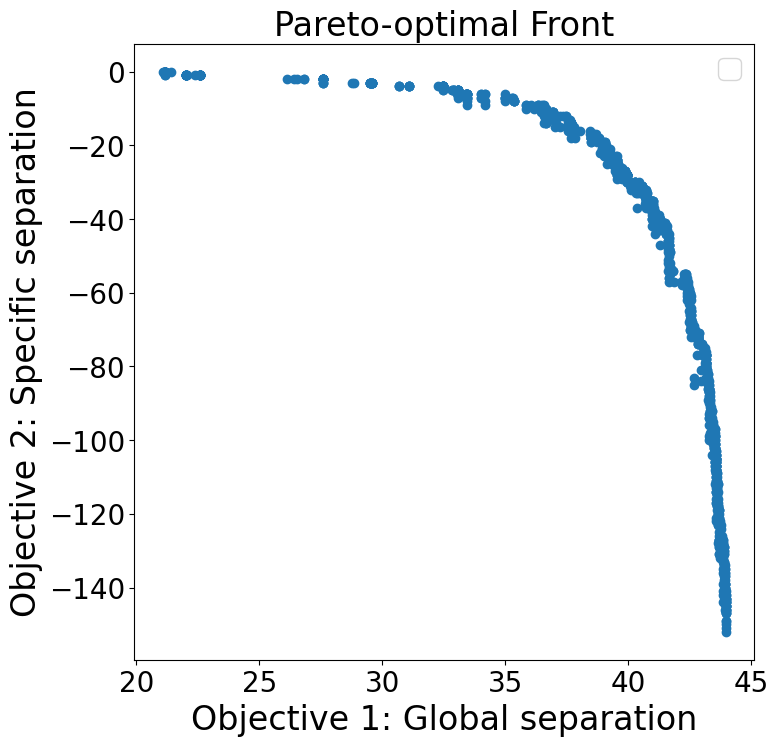

In [3]:
plt.figure(figsize=(8, 8))
plt.scatter(objectives[:, 0], objectives[:, 1])
plt.xlabel('Objective 1: Global separation', fontsize=24)
plt.ylabel('Objective 2: Specific separation', fontsize=24)
plt.title('Pareto-optimal Front', fontsize=24)
plt.tick_params(axis='x', labelsize=20)  
plt.tick_params(axis='y', labelsize=20) 

plt.legend(fontsize=20)
plt.show()



The shape of the Pareto front in optimization problem, convex or concave, changing with the desired minimum spacing (`desired_spacing_min`), can be attributed to the relationship between the objectives and the constraints imposed by the spacing between elements.

1. With Desired Spacing Min = 0.05: When the minimum desired spacing is smaller (0.05), the constraints on the solutions are less strict. This allows for a broader range of feasible solutions that can achieve a closer spacing without significantly impacting the sum of differences objective. The optimization can more easily adjust the spacing between the retention times (rts) to minimize both objectives, leading to a Pareto front that appears convex. In a convex Pareto front, improving one objective can still allow for reasonable values of the other objective without extreme trade-offs.

2. With Desired Spacing Min = 0.1: Increasing the minimum desired spacing to 0.1 imposes a stricter constraint on the feasible solutions. The solutions must now maintain a larger gap between the retention times, which can lead to increased difficulty in minimizing the sum of differences without adversely affecting the spacing objective. This stricter constraint makes it harder to find solutions that optimize both objectives simultaneously, leading to a concave Pareto front. In a concave front, the trade-offs between improving one objective and worsening the other become more pronounced, indicating that the objectives are in stronger conflict under the given constraints.



## Plotting the desired optimal gradient

In [4]:

pareto_front = objectives
#  sorts the front by the first objective (sum of differences)
pareto_front_sorted = pareto_front[pareto_front[:, 0].argsort()]

print(pareto_front_sorted)


[[  21.07263813    0.        ]
 [  21.14832657    0.        ]
 [  21.14832657    0.        ]
 ...
 [  43.9881601  -146.        ]
 [  43.9881601  -152.        ]
 [  43.9881601  -147.        ]]


we will plot the solution which has the fitness of 43.98575606 for objective 1 and -137 for objective 2  

In [5]:

# smallest difference in Objective 1 that still has a relatively high Objective 2
gradient = pareto_front_sorted[-1]  # starting from the last point which has the highest Objective 2 value


knee_solution_variables = algorithm.result[np.where(np.all(objectives ==gradient, axis=1))[0][0]].variables


df_sorted_by_perc_b = df.sort_values(by='perc_b').reset_index(drop=True)
perc_b_values = df_sorted_by_perc_b['perc_b'].values


knee_solution_variables = np.sort(knee_solution_variables)





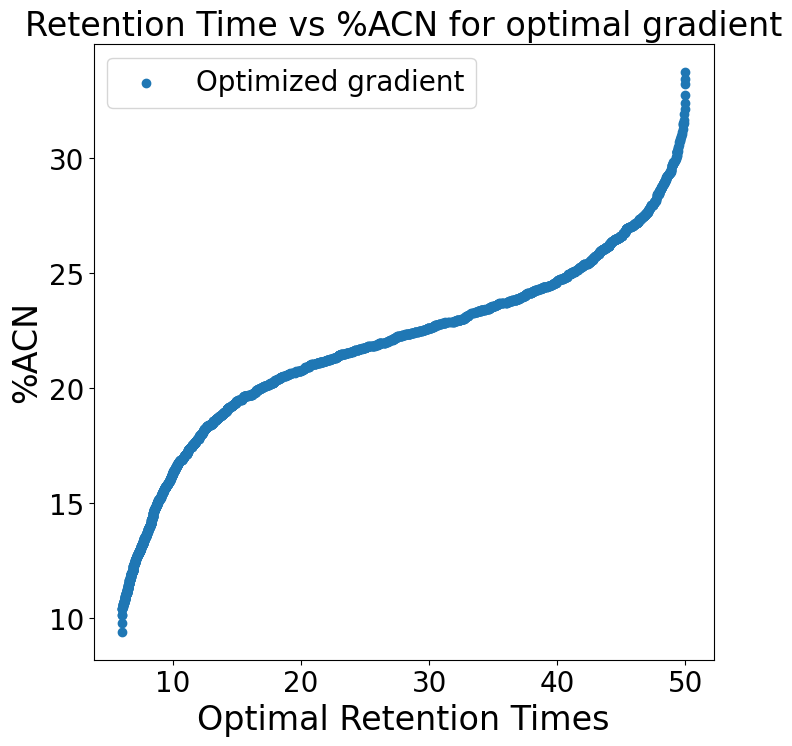

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(knee_solution_variables, perc_b_values[:len(knee_solution_variables)], label="Optimized gradient")
plt.xlabel('Optimal Retention Times',fontsize=24)
plt.ylabel('%ACN',fontsize=24)
plt.title('Retention Time vs %ACN for optimal gradient',fontsize=24)
plt.tick_params(axis='x', labelsize=20) 
plt.tick_params(axis='y', labelsize=20) 

plt.legend(fontsize=20)
plt.show()
